# Лекция 3: Токенизация

**Продължителност:** 2-2.5 часа  
**Предпоставки:** Лекция 2 (Невронни мрежи, embeddings)  
**Следваща лекция:** Механизми на внимание (Attention)

---
## Цели на лекцията

След тази лекция ще можете:

- Обяснявате защо токенизацията е критична за езиковите модели
- Сравнявате word-level, character-level и subword токенизация
- Имплементирате BPE алгоритъм от нулата
- Разбирате Unigram и WordPiece алгоритмите
- Работите с HuggingFace tokenizers и tiktoken в практически задачи

### Пътна карта

```
Мотивация → Нормализация → Word/Char → BPE (deep dive) → Unigram → Практика → LLM токенизатори
```

In [1]:
# Основни библиотеки
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
import re
import unicodedata

# Настройки
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

print("Библиотеките са заредени успешно.")

Библиотеките са заредени успешно.


---
## 1. Мотивация: Защо токенизацията е важна

### Припомняне от Лекция 2

В Лекция 2 изградихме текстов класификатор:

```
Текст → Токени → Token IDs → Embeddings → Neural Network → Output
```

**Използвахме проста токенизация:** разделяне по whitespace.

### Проблемът с embedding слоя

```python
nn.Embedding(vocab_size, embed_dim)
```

**Какво е `vocab_size`?**

- Всеки уникален токен има собствен embedding вектор
- Размерът на речника директно влияе на размера на модела
- **Въпрос:** Как да определим какво е "токен"?

In [2]:
# Какво е "дума"?
challenges = [
    ("New York", "Един град или две думи?"),
    ("don't", "Една дума или 'do' + 'not'?"),
    ("COVID-19", "Как да разделим?"),
    ("state-of-the-art", "Едно понятие, много тирета"),
    ("Bundesausbildungsförderungsgesetz", "Немски съставни думи"),
    ("中华人民共和国", "Китайски: няма интервали"),
    ("goooood", "Удължена дума в социални мрежи"),
]

print("Какво е 'дума'?\n")
for text, question in challenges:
    print(f"  {text:40s} → {question}")

Какво е 'дума'?

  New York                                 → Един град или две думи?
  don't                                    → Една дума или 'do' + 'not'?
  COVID-19                                 → Как да разделим?
  state-of-the-art                         → Едно понятие, много тирета
  Bundesausbildungsförderungsgesetz        → Немски съставни думи
  中华人民共和国                                  → Китайски: няма интервали
  goooood                                  → Удължена дума в социални мрежи


### Защо токенизацията определя качеството на модела

| Проблем | Последица |
|---------|----------|
| **OOV думи** | Модел не може да обработи нови/непознати думи |
| **Огромен речник** | Милиони думи = милиони embedding вектори = много памет |
| **Липса на генерализация** | "walk", "walks", "walked" са напълно различни вектори |
| **Дълги последователности** | Повече токени = повече compute и памет |

In [3]:
# Демонстрация: OOV (Out-of-Vocabulary) проблем
vocabulary = {'the', 'cat', 'sat', 'on', 'mat', 'dog', 'runs'}

test_sentences = [
    "the cat sat on the mat",
    "the dog runs",
    "the kitten sat quietly",
    "COVID-19 affects everyone",
]

print(f"Речник: {vocabulary}\n")

for sent in test_sentences:
    words = sent.lower().split()
    oov = [w for w in words if w not in vocabulary]
    status = "OK" if not oov else f"OOV: {oov}"
    print(f"  '{sent}'")
    print(f"  → {status}\n")

Речник: {'dog', 'on', 'runs', 'sat', 'cat', 'the', 'mat'}

  'the cat sat on the mat'
  → OK

  'the dog runs'
  → OK

  'the kitten sat quietly'
  → OOV: ['kitten', 'quietly']

  'COVID-19 affects everyone'
  → OOV: ['covid-19', 'affects', 'everyone']



### Три подхода за токенизация

| Подход | Токени | Пример за "playing" | Vocab size |
|--------|--------|---------------------|------------|
| **Word-level** | Цели думи | `["playing"]` | ~100K-1M |
| **Character-level** | Символи | `["p","l","a","y","i","n","g"]` | ~100-300 |
| **Subword** | Части от думи | `["play", "ing"]` | ~30K-100K |

---
## 2. Нормализация и предобработка

Преди токенизация обикновено прилагаме **нормализация** — стандартизиране на текста.

### 2.1 Case нормализация

**Въпрос:** "The" и "the" една дума ли са? А "Apple" (компания) и "apple" (плод)?

In [4]:
# Case sensitivity
text = "Apple released the new iPhone. I ate an apple."

words_original = text.split()
words_lower = text.lower().split()

print(f"Текст: '{text}'\n")
print(f"Case-sensitive:   {len(set(words_original))} уникални думи")
print(f"Case-insensitive: {len(set(words_lower))} уникални думи")

print("\nLowercase намалява речника, но губим информация:")
print("  'Apple' (компания) vs 'apple' (плод)")

Текст: 'Apple released the new iPhone. I ate an apple.'

Case-sensitive:   9 уникални думи
Case-insensitive: 9 уникални думи

Lowercase намалява речника, но губим информация:
  'Apple' (компания) vs 'apple' (плод)


### 2.2 Unicode нормализация

**Проблем:** Един и същ символ може да има различни Unicode представяния.

In [5]:
# Unicode: "é" може да бъде представено по различни начини
e_composed = 'é'           # NFC: един codepoint (U+00E9)
e_decomposed = 'e\u0301'   # NFD: 'e' + combining acute accent

print("Unicode представяния на 'é':\n")
print(f"  Composed (NFC):   '{e_composed}' → bytes: {e_composed.encode('utf-8')}")
print(f"  Decomposed (NFD): '{e_decomposed}' → bytes: {e_decomposed.encode('utf-8')}")

print(f"\n  Визуално еднакви? {e_composed} == {e_decomposed} визуално")
print(f"  Еднакви в Python? {e_composed == e_decomposed}")

# Нормализация
nfc = unicodedata.normalize('NFC', e_decomposed)
print(f"\n  След NFC нормализация: '{nfc}' == '{e_composed}' → {nfc == e_composed}")

Unicode представяния на 'é':

  Composed (NFC):   'é' → bytes: b'\xc3\xa9'
  Decomposed (NFD): 'é' → bytes: b'e\xcc\x81'

  Визуално еднакви? é == é визуално
  Еднакви в Python? False

  След NFC нормализация: 'é' == 'é' → True


### 2.3 Третиране на пунктуация

**Въпрос:** "Hello!" и "Hello" еднакви ли са? Какво правим с "don't"?

In [6]:
# Различни стратегии за пунктуация
text = "Hello, world! I'm learning NLP. It's state-of-the-art."

# Стратегия 1: Запазваме пунктуацията прикачена
tokens_attached = text.split()

# Стратегия 2: Разделяме пунктуацията
tokens_separated = re.findall(r"\w+|[^\w\s]", text)

# Стратегия 3: Премахваме пунктуацията
tokens_no_punct = re.findall(r"\w+", text)

print(f"Текст: '{text}'\n")
print(f"Прикачена:  {tokens_attached}")
print(f"Разделена:  {tokens_separated}")
print(f"Без punct:  {tokens_no_punct}")

Текст: 'Hello, world! I'm learning NLP. It's state-of-the-art.'

Прикачена:  ['Hello,', 'world!', "I'm", 'learning', 'NLP.', "It's", 'state-of-the-art.']
Разделена:  ['Hello', ',', 'world', '!', 'I', "'", 'm', 'learning', 'NLP', '.', 'It', "'", 's', 'state', '-', 'of', '-', 'the', '-', 'art', '.']
Без punct:  ['Hello', 'world', 'I', 'm', 'learning', 'NLP', 'It', 's', 'state', 'of', 'the', 'art']


### 2.4 Стемиране vs Лематизация

| Метод | Подход | "running" → | "better" → |
|-------|--------|-------------|------------|
| **Stemming** | Правила (отрязване) | "run" | "better" |
| **Lemmatization** | Речник | "run" | "good" |

**Забележка:** Съвременните LLM рядко използват stemming/lemmatization — оставят модела да научи морфологията.

In [7]:
# Stemming демонстрация (Porter Stemmer)
# Прост алгоритъм без NLTK

def simple_stem(word):
    """Опростен stemmer за демонстрация."""
    suffixes = ['ing', 'ed', 'es', 's', 'ly', 'er', 'est']
    for suffix in suffixes:
        if word.endswith(suffix) and len(word) > len(suffix) + 2:
            return word[:-len(suffix)]
    return word

words = ['running', 'runs', 'runner', 'walked', 'walking', 'happily', 'studies']

print("Прост stemming:\n")
for word in words:
    stem = simple_stem(word)
    print(f"  {word:12s} → {stem}")

print("\nStemming е бърз, но груб. Lemmatization е по-точна, но изисква речник.")

Прост stemming:

  running      → runn
  runs         → run
  runner       → runn
  walked       → walk
  walking      → walk
  happily      → happi
  studies      → studi

Stemming е бърз, но груб. Lemmatization е по-точна, но изисква речник.


---
## 3. Прости подходи за токенизация

### 3.1 Word-level токенизация

In [8]:
# Различни методи за word tokenization
text = "Hello, world! I'm learning NLP. It's state-of-the-art."

# Метод 1: Whitespace split
whitespace = text.split()

# Метод 2: Regex (само думи)
regex_words = re.findall(r'\w+', text)

# Метод 3: Regex (думи + пунктуация)
regex_all = re.findall(r"\w+|[^\w\s]", text)

print(f"Текст: '{text}'\n")
print(f"Whitespace:     {whitespace}")
print(f"Regex (\\w+):   {regex_words}")
print(f"Regex (+ punct): {regex_all}")

Текст: 'Hello, world! I'm learning NLP. It's state-of-the-art.'

Whitespace:     ['Hello,', 'world!', "I'm", 'learning', 'NLP.', "It's", 'state-of-the-art.']
Regex (\w+):   ['Hello', 'world', 'I', 'm', 'learning', 'NLP', 'It', 's', 'state', 'of', 'the', 'art']
Regex (+ punct): ['Hello', ',', 'world', '!', 'I', "'", 'm', 'learning', 'NLP', '.', 'It', "'", 's', 'state', '-', 'of', '-', 'the', '-', 'art', '.']


In [9]:
# Проблеми с word-level токенизация
print("Проблеми с word-level токенизация:\n")

print("1. ОГРОМЕН РЕЧНИК:")
print("   English Wikipedia: ~5M уникални думи")
print("   Google Books: ~100M уникални думи")
print("   → Embedding layer: 100M × 768 = 76.8 GB само за embeddings!")

print("\n2. OOV ПРОБЛЕМ:")
print("   Нови думи: 'chatgpt', 'cryptocurrency', 'covid'")
print("   Грешки: 'teh', 'recieve', 'definately'")
print("   → [UNK] токен губи цялата информация")

print("\n3. НЯМА СПОДЕЛЯНЕ:")
print("   'walk', 'walks', 'walked', 'walking' са 4 различни вектора")
print("   → Моделът не знае, че са свързани")

Проблеми с word-level токенизация:

1. ОГРОМЕН РЕЧНИК:
   English Wikipedia: ~5M уникални думи
   Google Books: ~100M уникални думи
   → Embedding layer: 100M × 768 = 76.8 GB само за embeddings!

2. OOV ПРОБЛЕМ:
   Нови думи: 'chatgpt', 'cryptocurrency', 'covid'
   Грешки: 'teh', 'recieve', 'definately'
   → [UNK] токен губи цялата информация

3. НЯМА СПОДЕЛЯНЕ:
   'walk', 'walks', 'walked', 'walking' са 4 различни вектора
   → Моделът не знае, че са свързани


### 3.2 Character-level токенизация

**Идея:** Всеки символ е токен.

In [10]:
# Character-level токенизация
text = "Hello NLP!"

char_tokens = list(text)

print(f"Текст: '{text}'")
print(f"Токени: {char_tokens}")
print(f"Брой токени: {len(char_tokens)}")

print("\nРазмер на речника:")
print("  ASCII букви + цифри + punct: ~100 символа")
print("  Пълен Unicode: ~150,000 символа")

Текст: 'Hello NLP!'
Токени: ['H', 'e', 'l', 'l', 'o', ' ', 'N', 'L', 'P', '!']
Брой токени: 10

Размер на речника:
  ASCII букви + цифри + punct: ~100 символа
  Пълен Unicode: ~150,000 символа


In [11]:
# Проблеми с character-level
sentence = "The quick brown fox jumps over the lazy dog."

word_tokens = sentence.split()
char_tokens = list(sentence)

print(f"Текст: '{sentence}'\n")
print(f"Word tokens: {len(word_tokens)} токена")
print(f"Char tokens: {len(char_tokens)} токена")
print(f"\nСъотношение: {len(char_tokens)/len(word_tokens):.1f}x по-дълга последователност")

print("\nПроблеми:")
print("  1. Много дълги последователности → повече compute")
print("  2. Символите имат малко семантично значение")
print("  3. Труднo за модела да научи дълги зависимости")

Текст: 'The quick brown fox jumps over the lazy dog.'

Word tokens: 9 токена
Char tokens: 44 токена

Съотношение: 4.9x по-дълга последователност

Проблеми:
  1. Много дълги последователности → повече compute
  2. Символите имат малко семантично значение
  3. Труднo за модела да научи дълги зависимости


### 3.3 Trade-off: Vocabulary size vs Sequence length

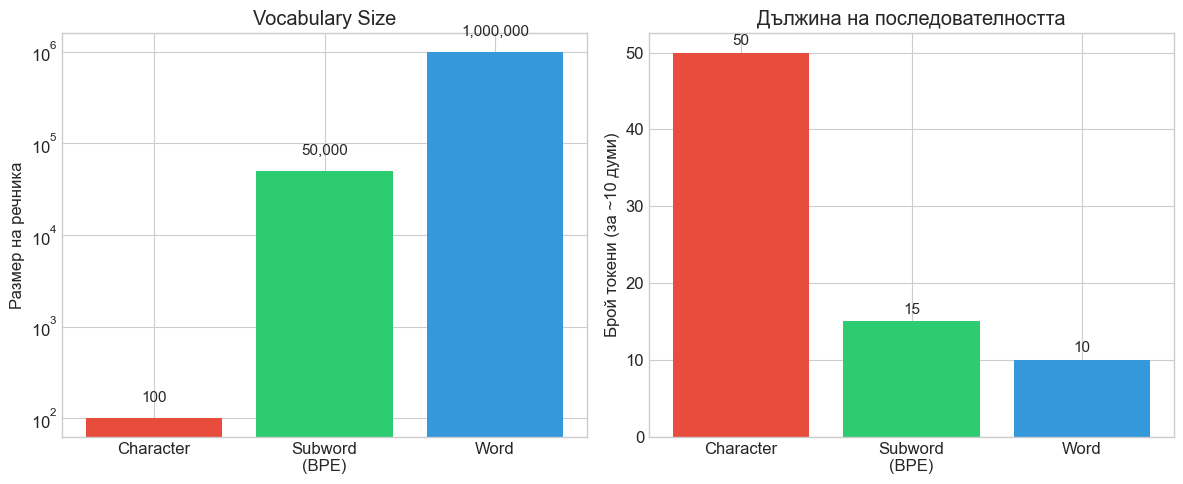

Subword токенизация е 'златната среда':
  - Умерен размер на речника (~30K-100K)
  - Разумна дължина на последователностите
  - Няма OOV (всичко може да се разбие до символи/bytes)


In [12]:
# Визуализация на trade-off
approaches = ['Character', 'Subword\n(BPE)', 'Word']
vocab_sizes = [100, 50000, 1000000]
seq_lengths = [50, 15, 10]  # за същия текст

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

colors = ['#e74c3c', '#2ecc71', '#3498db']

# Vocabulary size
axes[0].bar(approaches, vocab_sizes, color=colors)
axes[0].set_ylabel('Размер на речника')
axes[0].set_title('Vocabulary Size')
axes[0].set_yscale('log')
for i, v in enumerate(vocab_sizes):
    axes[0].text(i, v*1.5, f'{v:,}', ha='center', fontsize=11)

# Sequence length
axes[1].bar(approaches, seq_lengths, color=colors)
axes[1].set_ylabel('Брой токени (за ~10 думи)')
axes[1].set_title('Дължина на последователността')
for i, v in enumerate(seq_lengths):
    axes[1].text(i, v+1, str(v), ha='center', fontsize=11)

plt.tight_layout()
plt.show()

print("Subword токенизация е 'златната среда':")
print("  - Умерен размер на речника (~30K-100K)")
print("  - Разумна дължина на последователностите")
print("  - Няма OOV (всичко може да се разбие до символи/bytes)")

---
## 4. Subword токенизация: BPE и Unigram

### Ключова идея

**Subword tokenization** разбива думите на смислени части:
- Чести думи → един токен: "the", "and", "is"
- Редки думи → няколко токена: "un" + "happi" + "ness"

**Предимства:**
- Фиксиран речник (30K-100K)
- Няма OOV — всичко се разбива до символи/bytes
- Споделяне: "play", "playing", "replay" споделят "play"

### 4.1 Byte-Pair Encoding (BPE) — Deep Dive

**Философия:** Bottom-up, greedy, frequency-based

**Алгоритъм за обучение:**
1. Започни с речник от всички символи
2. Намери най-честата двойка съседни символи
3. Обедини ги в нов символ
4. Повтаряй докато речникът достигне желания размер

**Използва се от:** GPT-2, GPT-3, GPT-4, LLaMA, RoBERTa

In [13]:
# Примерен корпус за BPE демонстрация
corpus = [
    "low", "low", "low", "low", "low",
    "lower", "lower",
    "newest", "newest", "newest", "newest", "newest", "newest",
    "widest", "widest", "widest"
]

word_freq = Counter(corpus)

print("Корпус (честота на думите):\n")
for word, count in word_freq.items():
    print(f"  '{word}': {count}")

Корпус (честота на думите):

  'low': 5
  'lower': 2
  'newest': 6
  'widest': 3


In [14]:
# BPE Стъпка 1: Инициализация — разбиваме на символи
def initialize_vocab(word_freq):
    """Разбива всяка дума на символи с маркер за край на дума."""
    vocab = {}
    for word, freq in word_freq.items():
        # Добавяме </w> като маркер за край на дума
        chars = list(word) + ['</w>']
        vocab[' '.join(chars)] = freq
    return vocab

vocab = initialize_vocab(word_freq)

print("Начален речник (символи):\n")
for word, freq in vocab.items():
    print(f"  [{word}] : {freq}")

# Извличаме уникалните символи
all_symbols = set()
for word in vocab:
    all_symbols.update(word.split())

print(f"\nУникални символи: {sorted(all_symbols)}")

Начален речник (символи):

  [l o w </w>] : 5
  [l o w e r </w>] : 2
  [n e w e s t </w>] : 6
  [w i d e s t </w>] : 3

Уникални символи: ['</w>', 'd', 'e', 'i', 'l', 'n', 'o', 'r', 's', 't', 'w']


In [15]:
# BPE Стъпка 2: Намираме най-честата двойка
def get_pair_counts(vocab):
    """Брои всички съседни двойки символи."""
    pairs = Counter()
    for word, freq in vocab.items():
        symbols = word.split()
        for i in range(len(symbols) - 1):
            pair = (symbols[i], symbols[i+1])
            pairs[pair] += freq
    return pairs

pairs = get_pair_counts(vocab)

print("Честота на двойките:\n")
for pair, count in pairs.most_common(10):
    print(f"  {pair}: {count}")

best_pair = pairs.most_common(1)[0]
print(f"\nНай-честа двойка: {best_pair[0]} (честота: {best_pair[1]})")

Честота на двойките:

  ('e', 's'): 9
  ('s', 't'): 9
  ('t', '</w>'): 9
  ('w', 'e'): 8
  ('l', 'o'): 7
  ('o', 'w'): 7
  ('n', 'e'): 6
  ('e', 'w'): 6
  ('w', '</w>'): 5
  ('w', 'i'): 3

Най-честа двойка: ('e', 's') (честота: 9)


In [16]:
# BPE Стъпка 3: Обединяваме най-честата двойка
def merge_pair(pair, vocab):
    """Обединява двойка символи навсякъде в речника."""
    new_vocab = {}
    bigram = ' '.join(pair)
    replacement = ''.join(pair)
    
    for word, freq in vocab.items():
        new_word = word.replace(bigram, replacement)
        new_vocab[new_word] = freq
    
    return new_vocab

# Извършваме първото сливане
best = pairs.most_common(1)[0][0]
vocab = merge_pair(best, vocab)

print(f"Merge #1: {best[0]} + {best[1]} → {''.join(best)}\n")
print("Нов речник:")
for word, freq in vocab.items():
    print(f"  [{word}] : {freq}")

Merge #1: e + s → es

Нов речник:
  [l o w </w>] : 5
  [l o w e r </w>] : 2
  [n e w es t </w>] : 6
  [w i d es t </w>] : 3


In [17]:
# Пълна BPE имплементация
def train_bpe(word_freq, num_merges):
    """Обучава BPE tokenizer."""
    vocab = initialize_vocab(word_freq)
    merges = []  # Записваме реда на сливанията
    
    print(f"BPE обучение ({num_merges} merge операции):\n")
    
    for i in range(num_merges):
        pairs = get_pair_counts(vocab)
        if not pairs:
            break
        
        best_pair = pairs.most_common(1)[0][0]
        vocab = merge_pair(best_pair, vocab)
        merges.append(best_pair)
        
        merged = ''.join(best_pair)
        print(f"  Merge #{i+1}: {best_pair[0]:8s} + {best_pair[1]:8s} → {merged}")
    
    return vocab, merges

# Обучаваме с 10 сливания
final_vocab, merge_rules = train_bpe(word_freq, num_merges=10)

BPE обучение (10 merge операции):

  Merge #1: e        + s        → es
  Merge #2: es       + t        → est
  Merge #3: est      + </w>     → est</w>
  Merge #4: l        + o        → lo
  Merge #5: lo       + w        → low
  Merge #6: n        + e        → ne
  Merge #7: ne       + w        → new
  Merge #8: new      + est</w>  → newest</w>
  Merge #9: low      + </w>     → low</w>
  Merge #10: w        + i        → wi


In [18]:
# Финален BPE речник
print("Финален BPE речник:\n")
for word, freq in final_vocab.items():
    print(f"  [{word}] : {freq}")

# Извличаме всички токени
all_tokens = set()
for word in final_vocab:
    all_tokens.update(word.split())

print(f"\nТокени в речника ({len(all_tokens)}):")
print(f"  {sorted(all_tokens)}")

Финален BPE речник:

  [low</w>] : 5
  [low e r </w>] : 2
  [newest</w>] : 6
  [wi d est</w>] : 3

Токени в речника (9):
  ['</w>', 'd', 'e', 'est</w>', 'low', 'low</w>', 'newest</w>', 'r', 'wi']


### BPE Encoding: Токенизация на нов текст

**Алгоритъм:**
1. Разбий думата на символи
2. Приложи merge правилата в реда, в който са научени
3. Резултатът е токенизираната дума

In [19]:
# BPE Encoding
def bpe_encode(word, merges):
    """Токенизира дума с BPE merge rules."""
    # Започваме със символи
    tokens = list(word) + ['</w>']
    
    # Прилагаме merge правилата в реда, в който са научени
    for pair in merges:
        i = 0
        while i < len(tokens) - 1:
            if tokens[i] == pair[0] and tokens[i+1] == pair[1]:
                tokens = tokens[:i] + [''.join(pair)] + tokens[i+2:]
            else:
                i += 1
    
    return tokens

# Тестваме
test_words = ['low', 'lower', 'lowest', 'newest', 'wider', 'unknown']

print("BPE Encoding:\n")
for word in test_words:
    tokens = bpe_encode(word, merge_rules)
    print(f"  {word:12s} → {tokens}")

print("\n'lowest' се токенизира въпреки че не е в корпуса!")
print("BPE може да обработи всяка дума чрез subword разбивка.")

BPE Encoding:

  low          → ['low</w>']
  lower        → ['low', 'e', 'r', '</w>']
  lowest       → ['low', 'est</w>']
  newest       → ['newest</w>']
  wider        → ['wi', 'd', 'e', 'r', '</w>']
  unknown      → ['u', 'n', 'k', 'n', 'o', 'w', 'n', '</w>']

'lowest' се токенизира въпреки че не е в корпуса!
BPE може да обработи всяка дума чрез subword разбивка.


In [20]:
# Визуализация на BPE encoding стъпки
def visualize_bpe_encoding(word, merges):
    """Показва стъпките на BPE encoding."""
    tokens = list(word) + ['</w>']
    steps = [tokens.copy()]
    
    for pair in merges:
        changed = False
        i = 0
        while i < len(tokens) - 1:
            if tokens[i] == pair[0] and tokens[i+1] == pair[1]:
                tokens = tokens[:i] + [''.join(pair)] + tokens[i+2:]
                changed = True
            else:
                i += 1
        if changed:
            steps.append(tokens.copy())
    
    return steps

word = "newest"
steps = visualize_bpe_encoding(word, merge_rules)

print(f"BPE encoding стъпки за '{word}':\n")
for i, step in enumerate(steps):
    prefix = "Start:" if i == 0 else f"Step {i}:"
    print(f"  {prefix:8s} {step}")

BPE encoding стъпки за 'newest':

  Start:   ['n', 'e', 'w', 'e', 's', 't', '</w>']
  Step 1:  ['n', 'e', 'w', 'es', 't', '</w>']
  Step 2:  ['n', 'e', 'w', 'est', '</w>']
  Step 3:  ['n', 'e', 'w', 'est</w>']
  Step 4:  ['ne', 'w', 'est</w>']
  Step 5:  ['new', 'est</w>']
  Step 6:  ['newest</w>']


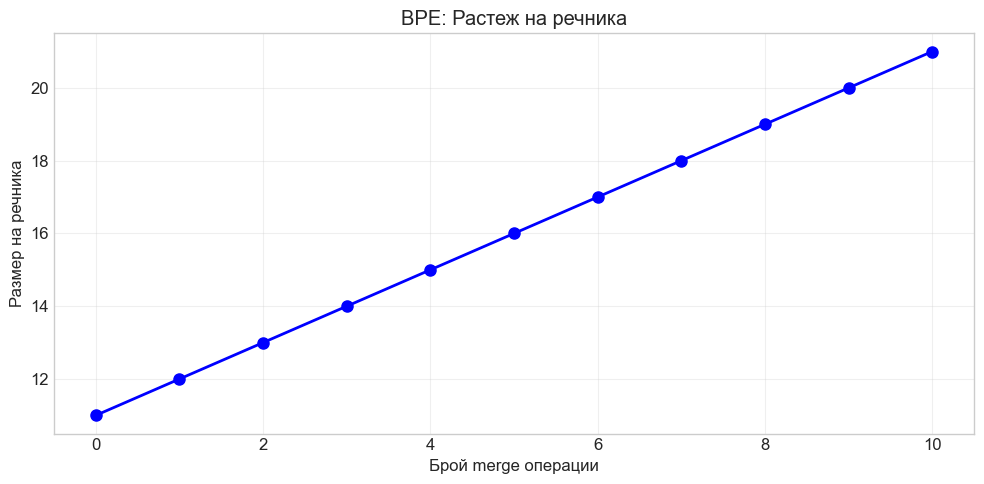

BPE vocabulary = base_chars + num_merges
GPT-2: 256 bytes + 50,000 merges = 50,256 токена


In [21]:
# Визуализация: Как расте речникът
def track_vocab_growth(word_freq, num_merges):
    """Следи растежа на речника."""
    vocab = initialize_vocab(word_freq)
    
    # Начален брой символи
    initial_symbols = set()
    for word in vocab:
        initial_symbols.update(word.split())
    
    sizes = [len(initial_symbols)]
    
    for i in range(num_merges):
        pairs = get_pair_counts(vocab)
        if not pairs:
            break
        best_pair = pairs.most_common(1)[0][0]
        vocab = merge_pair(best_pair, vocab)
        sizes.append(sizes[-1] + 1)  # Всеки merge добавя 1 нов токен
    
    return sizes

sizes = track_vocab_growth(word_freq, 10)

plt.figure(figsize=(10, 5))
plt.plot(range(len(sizes)), sizes, 'b-o', linewidth=2, markersize=8)
plt.xlabel('Брой merge операции')
plt.ylabel('Размер на речника')
plt.title('BPE: Растеж на речника')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("BPE vocabulary = base_chars + num_merges")
print("GPT-2: 256 bytes + 50,000 merges = 50,256 токена")

### 4.2 Unigram Language Model Tokenization — Deep Dive

**Философия:** Top-down, probabilistic, likelihood-based

**Разлика от BPE:**
- BPE: greedy, добавя токени (bottom-up)
- Unigram: вероятностен, премахва токени (top-down)

**Алгоритъм:**
1. Започни с голям речник (всички символи + чести substrings)
2. За всеки токен изчисли как се променя likelihood ако го премахнем
3. Премахни токените с най-малък impact
4. Повтаряй докато речникът достигне желания размер

**Използва се от:** T5, ALBERT, mBART, XLNet

In [22]:
# Unigram: Множество възможни сегментации
word = "unhappiness"

segmentations = [
    ["un", "happiness"],
    ["un", "happy", "ness"],
    ["un", "happ", "iness"],
    ["unhapp", "iness"],
    ["u", "n", "h", "a", "p", "p", "i", "n", "e", "s", "s"],
]

print(f"Дума: '{word}'\n")
print("Възможни сегментации:")
for seg in segmentations:
    print(f"  {seg}")

print("\nUnigram избира сегментацията с най-висока вероятност!")

Дума: 'unhappiness'

Възможни сегментации:
  ['un', 'happiness']
  ['un', 'happy', 'ness']
  ['un', 'happ', 'iness']
  ['unhapp', 'iness']
  ['u', 'n', 'h', 'a', 'p', 'p', 'i', 'n', 'e', 's', 's']

Unigram избира сегментацията с най-висока вероятност!


### Unigram математика

**Вероятност на сегментация:**
$$P(x_1, x_2, ..., x_n) = \prod_{i=1}^{n} P(x_i)$$

**Най-вероятна сегментация:** (използва се Viterbi алгоритъм)
$$x^* = \arg\max_x P(x)$$

**Пример:**
- P("un") = 0.01, P("happiness") = 0.001
- P(["un", "happiness"]) = 0.01 × 0.001 = 0.00001

In [23]:
# Симулация на Unigram вероятности
# (В реалност се учат от корпус)

token_probs = {
    'un': 0.01,
    'happiness': 0.001,
    'happy': 0.005,
    'ness': 0.008,
    'happ': 0.0001,
    'iness': 0.0002,
    'unhapp': 0.00001,
}

def segmentation_prob(tokens, probs):
    """Изчислява вероятността на сегментация."""
    prob = 1.0
    for t in tokens:
        prob *= probs.get(t, 0.0001)  # fallback за непознати
    return prob

segmentations = [
    ["un", "happiness"],
    ["un", "happy", "ness"],
    ["un", "happ", "iness"],
    ["unhapp", "iness"],
]

print("Unigram вероятности на сегментации:\n")
print(f"{'Сегментация':<30} {'Вероятност':>15} {'Log-prob':>12}")
print("-" * 58)

best_prob = 0
best_seg = None

for seg in segmentations:
    prob = segmentation_prob(seg, token_probs)
    log_prob = np.log(prob) if prob > 0 else float('-inf')
    print(f"{str(seg):<30} {prob:>15.2e} {log_prob:>12.2f}")
    
    if prob > best_prob:
        best_prob = prob
        best_seg = seg

print(f"\nНай-вероятна сегментация: {best_seg}")

Unigram вероятности на сегментации:

Сегментация                         Вероятност     Log-prob
----------------------------------------------------------
['un', 'happiness']                   1.00e-05       -11.51
['un', 'happy', 'ness']               4.00e-07       -14.73
['un', 'happ', 'iness']               2.00e-10       -22.33
['unhapp', 'iness']                   2.00e-09       -20.03

Най-вероятна сегментация: ['un', 'happiness']


### 4.3 BPE vs Unigram: Сравнение

| Характеристика | BPE | Unigram |
|----------------|-----|--------|
| **Подход** | Bottom-up (добавя) | Top-down (премахва) |
| **Критерий** | Честота | Likelihood |
| **Детерминистичен** | Да | Може да семплира |
| **Множество токенизации** | Не | Да |
| **Модели** | GPT, LLaMA | T5, ALBERT |

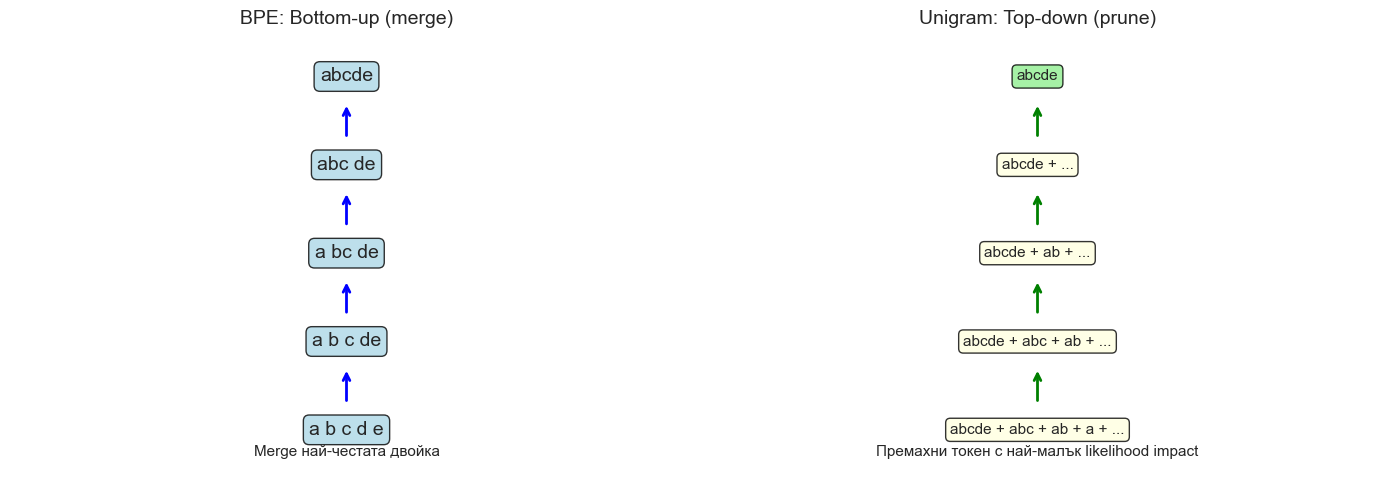

In [24]:
# Визуално сравнение на подходите
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# BPE: Bottom-up
ax1 = axes[0]
levels_bpe = ['a b c d e', 'a b c de', 'a bc de', 'abc de', 'abcde']

for i, level in enumerate(levels_bpe):
    ax1.text(0.5, i, level, ha='center', va='center', fontsize=14,
             bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
    if i < len(levels_bpe) - 1:
        ax1.annotate('', xy=(0.5, i+0.7), xytext=(0.5, i+0.3),
                    arrowprops=dict(arrowstyle='->', color='blue', lw=2))

ax1.set_xlim(0, 1)
ax1.set_ylim(-0.5, len(levels_bpe)-0.5)
ax1.set_title('BPE: Bottom-up (merge)', fontsize=14)
ax1.axis('off')
ax1.text(0.5, -0.3, 'Merge най-честата двойка', ha='center', fontsize=11)

# Unigram: Top-down
ax2 = axes[1]
levels_uni = ['abcde + abc + ab + a + ...', 'abcde + abc + ab + ...', 
              'abcde + ab + ...', 'abcde + ...', 'abcde']

for i, level in enumerate(levels_uni):
    color = 'lightgreen' if i == len(levels_uni)-1 else 'lightyellow'
    ax2.text(0.5, i, level, ha='center', va='center', fontsize=11,
             bbox=dict(boxstyle='round', facecolor=color, alpha=0.8))
    if i < len(levels_uni) - 1:
        ax2.annotate('', xy=(0.5, i+0.7), xytext=(0.5, i+0.3),
                    arrowprops=dict(arrowstyle='->', color='green', lw=2))

ax2.set_xlim(0, 1)
ax2.set_ylim(-0.5, len(levels_uni)-0.5)
ax2.set_title('Unigram: Top-down (prune)', fontsize=14)
ax2.axis('off')
ax2.text(0.5, -0.3, 'Премахни токен с най-малък likelihood impact', ha='center', fontsize=11)

plt.tight_layout()
plt.show()

### 4.4 WordPiece (кратко)

**Използва се от:** BERT, DistilBERT, ELECTRA

**Подобен на BPE, но:**
- Избира merge въз основа на likelihood gain, не честота
- Използва `##` префикс за continuation tokens

**Пример:** "playing" → ["play", "##ing"]

In [25]:
# WordPiece пример (симулация)
print("WordPiece токенизация (BERT стил):\n")

examples = [
    ("playing", ["play", "##ing"]),
    ("unhappiness", ["un", "##hap", "##pi", "##ness"]),
    ("tokenization", ["token", "##ization"]),
    ("embeddings", ["em", "##bed", "##ding", "##s"]),
]

for word, tokens in examples:
    print(f"  {word:15s} → {tokens}")

print("\n'##' означава, че токенът продължава предишен (не е начало на дума)")

WordPiece токенизация (BERT стил):

  playing         → ['play', '##ing']
  unhappiness     → ['un', '##hap', '##pi', '##ness']
  tokenization    → ['token', '##ization']
  embeddings      → ['em', '##bed', '##ding', '##s']

'##' означава, че токенът продължава предишен (не е начало на дума)


---
## 5. Практическа токенизация

### 5.1 Специални токени

Всеки tokenizer има специални токени за различни цели:

In [26]:
# Специални токени в различни модели
special_tokens = {
    'BERT': {
        '[CLS]': 'Начало на input (за classification)',
        '[SEP]': 'Разделител между изречения',
        '[PAD]': 'Padding до еднаква дължина',
        '[MASK]': 'Маскиран токен (за MLM)',
        '[UNK]': 'Непознат токен',
    },
    'GPT': {
        '<|endoftext|>': 'Край на текст/документ',
        '<|startoftext|>': 'Начало на текст',
    },
    'LLaMA': {
        '<s>': 'Начало на sequence (BOS)',
        '</s>': 'Край на sequence (EOS)',
        '<unk>': 'Непознат токен',
    }
}

print("Специални токени по модел:\n")
for model, tokens in special_tokens.items():
    print(f"  {model}:")
    for token, desc in tokens.items():
        print(f"    {token:20s} → {desc}")
    print()

Специални токени по модел:

  BERT:
    [CLS]                → Начало на input (за classification)
    [SEP]                → Разделител между изречения
    [PAD]                → Padding до еднаква дължина
    [MASK]               → Маскиран токен (за MLM)
    [UNK]                → Непознат токен

  GPT:
    <|endoftext|>        → Край на текст/документ
    <|startoftext|>      → Начало на текст

  LLaMA:
    <s>                  → Начало на sequence (BOS)
    </s>                 → Край на sequence (EOS)
    <unk>                → Непознат токен



### 5.2 HuggingFace Tokenizers

Най-популярната библиотека за работа с токенизатори.

In [27]:
# Проверка за инсталирани библиотеки
try:
    from transformers import AutoTokenizer
    HF_AVAILABLE = True
    print("HuggingFace transformers е наличен!")
except ImportError:
    HF_AVAILABLE = False
    print("HuggingFace transformers не е инсталиран.")
    print("Инсталирайте с: pip install transformers")

try:
    import tiktoken
    TIKTOKEN_AVAILABLE = True
    print("tiktoken е наличен!")
except ImportError:
    TIKTOKEN_AVAILABLE = False
    print("tiktoken не е инсталиран.")
    print("Инсталирайте с: pip install tiktoken")

HuggingFace transformers е наличен!
tiktoken е наличен!


In [28]:
# Зареждаме BERT tokenizer
if HF_AVAILABLE:
    bert_tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
    
    print(f"BERT tokenizer:")
    print(f"  Тип: WordPiece")
    print(f"  Размер на речника: {bert_tokenizer.vocab_size:,}")
else:
    print("BERT tokenizer не е наличен (transformers не е инсталиран)")

BERT tokenizer:
  Тип: WordPiece
  Размер на речника: 30,522


In [29]:
# BERT токенизация
if HF_AVAILABLE:
    text = "I love machine learning and natural language processing!"
    
    tokens = bert_tokenizer.tokenize(text)
    token_ids = bert_tokenizer.encode(text)
    
    print(f"Текст: '{text}'\n")
    print(f"Токени: {tokens}")
    print(f"Token IDs: {token_ids}")
    print(f"Брой токени: {len(tokens)}")
    
    # Decode обратно
    decoded = bert_tokenizer.decode(token_ids)
    print(f"\nDecoded: '{decoded}'")

Текст: 'I love machine learning and natural language processing!'

Токени: ['i', 'love', 'machine', 'learning', 'and', 'natural', 'language', 'processing', '!']
Token IDs: [101, 1045, 2293, 3698, 4083, 1998, 3019, 2653, 6364, 999, 102]
Брой токени: 9

Decoded: '[CLS] i love machine learning and natural language processing! [SEP]'


In [30]:
# Зареждаме GPT-2 tokenizer
if HF_AVAILABLE:
    gpt2_tokenizer = AutoTokenizer.from_pretrained('gpt2')
    
    print(f"GPT-2 tokenizer:")
    print(f"  Тип: BPE (byte-level)")
    print(f"  Размер на речника: {gpt2_tokenizer.vocab_size:,}")

GPT-2 tokenizer:
  Тип: BPE (byte-level)
  Размер на речника: 50,257


In [31]:
# Сравнение: BERT vs GPT-2
if HF_AVAILABLE:
    text = "Tokenization is fundamental to NLP."
    
    bert_tokens = bert_tokenizer.tokenize(text)
    gpt2_tokens = gpt2_tokenizer.tokenize(text)
    
    print(f"Текст: '{text}'\n")
    print(f"BERT (WordPiece):  {bert_tokens}")
    print(f"GPT-2 (BPE):       {gpt2_tokens}")
    
    print(f"\nБрой токени:")
    print(f"  BERT:  {len(bert_tokens)}")
    print(f"  GPT-2: {len(gpt2_tokens)}")

Текст: 'Tokenization is fundamental to NLP.'

BERT (WordPiece):  ['token', '##ization', 'is', 'fundamental', 'to', 'nl', '##p', '.']
GPT-2 (BPE):       ['Token', 'ization', 'Ġis', 'Ġfundamental', 'Ġto', 'ĠN', 'LP', '.']

Брой токени:
  BERT:  8
  GPT-2: 8


In [32]:
# Сравнение с повече примери
if HF_AVAILABLE:
    examples = [
        "Hello world!",
        "Machine learning is amazing.",
        "Unhappiness leads to introspection.",
        "COVID-19 pandemic affected everyone.",
        "Supercalifragilisticexpialidocious",
    ]
    
    print("Сравнение BERT vs GPT-2:\n")
    print(f"{'Текст':<45} {'BERT':>6} {'GPT-2':>6}")
    print("-" * 60)
    
    for text in examples:
        bert_len = len(bert_tokenizer.tokenize(text))
        gpt2_len = len(gpt2_tokenizer.tokenize(text))
        display = text[:42] + "..." if len(text) > 45 else text
        print(f"{display:<45} {bert_len:>6} {gpt2_len:>6}")

Сравнение BERT vs GPT-2:

Текст                                           BERT  GPT-2
------------------------------------------------------------
Hello world!                                       3      3
Machine learning is amazing.                       5      5
Unhappiness leads to introspection.               10      8
COVID-19 pandemic affected everyone.              10      9
Supercalifragilisticexpialidocious                11     11


### 5.3 tiktoken (OpenAI)

Бърз BPE tokenizer, използван от GPT-3.5/4.

In [33]:
# tiktoken демонстрация
if TIKTOKEN_AVAILABLE:
    import tiktoken
    
    # Encoding за GPT-4
    enc = tiktoken.encoding_for_model("gpt-4")
    
    text = "Hello, how are you doing today?"
    tokens = enc.encode(text)
    
    print(f"tiktoken (GPT-4 encoding):\n")
    print(f"  Текст: '{text}'")
    print(f"  Token IDs: {tokens}")
    print(f"  Брой токени: {len(tokens)}")
    
    # Показваме какво е всеки токен
    print(f"\n  Токени:")
    for tid in tokens:
        token_bytes = enc.decode_single_token_bytes(tid)
        print(f"    {tid:6d} → {token_bytes}")
else:
    print("tiktoken не е инсталиран.")

tiktoken (GPT-4 encoding):

  Текст: 'Hello, how are you doing today?'
  Token IDs: [9906, 11, 1268, 527, 499, 3815, 3432, 30]
  Брой токени: 8

  Токени:
      9906 → b'Hello'
        11 → b','
      1268 → b' how'
       527 → b' are'
       499 → b' you'
      3815 → b' doing'
      3432 → b' today'
        30 → b'?'


### 5.4 Training Custom Tokenizer

**Кога да обучавате собствен tokenizer?**
- Специализиран домейн (код, медицински, правен текст)
- Език, който не е добре представен в pre-trained tokenizers
- Много специфичен vocabulary

**Обичайно:** Използвайте готов tokenizer от модела, който ще използвате!

---
## 6. Токенизация в съвременни LLM

### 6.1 Сравнение на LLM токенизатори

In [34]:
# Таблица с токенизатори на популярни модели
llm_tokenizers = {
    'GPT-2': {'type': 'BPE', 'vocab': 50257, 'note': 'Byte-level'},
    'GPT-3.5/4': {'type': 'BPE', 'vocab': 100000, 'note': 'cl100k_base'},
    'BERT': {'type': 'WordPiece', 'vocab': 30522, 'note': 'Uncased'},
    'T5': {'type': 'Unigram', 'vocab': 32000, 'note': 'SentencePiece'},
    'LLaMA': {'type': 'BPE', 'vocab': 32000, 'note': 'SentencePiece'},
    'LLaMA 2/3': {'type': 'BPE', 'vocab': 32000, 'note': 'SentencePiece'},
    'Mistral': {'type': 'BPE', 'vocab': 32000, 'note': 'SentencePiece'},
    'Claude': {'type': 'BPE', 'vocab': '~100k', 'note': 'Byte-level'},
}

print("Токенизатори в популярни LLM:\n")
print(f"{'Модел':<15} {'Тип':<12} {'Vocab Size':<12} {'Бележка'}")
print("-" * 55)

for model, info in llm_tokenizers.items():
    vocab = str(info['vocab'])
    print(f"{model:<15} {info['type']:<12} {vocab:<12} {info['note']}")

Токенизатори в популярни LLM:

Модел           Тип          Vocab Size   Бележка
-------------------------------------------------------
GPT-2           BPE          50257        Byte-level
GPT-3.5/4       BPE          100000       cl100k_base
BERT            WordPiece    30522        Uncased
T5              Unigram      32000        SentencePiece
LLaMA           BPE          32000        SentencePiece
LLaMA 2/3       BPE          32000        SentencePiece
Mistral         BPE          32000        SentencePiece
Claude          BPE          ~100k        Byte-level


### 6.2 Vocabulary size trade-off

| По-малък речник (30K) | По-голям речник (100K) |
|----------------------|------------------------|
| По-дълги последователности | По-кратки последователности |
| По-малко параметри в embedding | Повече параметри |
| По-добра генерализация | По-добро покритие |

**GPT-2:** vocab = 50,257 = 256 bytes + 50,000 merges + 1 special token

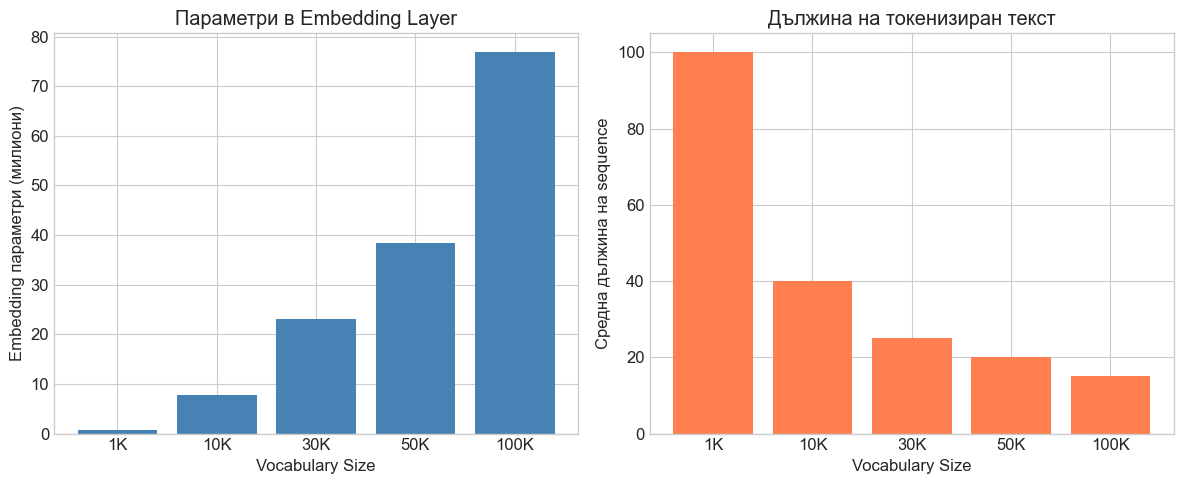

По-голям речник = повече памет за embeddings, но по-кратки sequences


In [35]:
# Визуализация: Impact на vocabulary size
vocab_sizes = [1000, 10000, 30000, 50000, 100000]
embedding_dim = 768  # BERT-base

# Параметри в embedding layer = vocab_size × embedding_dim
params = [v * embedding_dim / 1e6 for v in vocab_sizes]  # в милиони

# Примерна дължина на последователност (обратно пропорционална)
seq_lengths = [100, 40, 25, 20, 15]  # примерни стойности

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Embedding parameters
axes[0].bar([f'{v//1000}K' for v in vocab_sizes], params, color='steelblue')
axes[0].set_xlabel('Vocabulary Size')
axes[0].set_ylabel('Embedding параметри (милиони)')
axes[0].set_title('Параметри в Embedding Layer')

# Sequence length
axes[1].bar([f'{v//1000}K' for v in vocab_sizes], seq_lengths, color='coral')
axes[1].set_xlabel('Vocabulary Size')
axes[1].set_ylabel('Средна дължина на sequence')
axes[1].set_title('Дължина на токенизиран текст')

plt.tight_layout()
plt.show()

print("По-голям речник = повече памет за embeddings, но по-кратки sequences")

### 6.3 Token limits и context windows

**Важно:** Когато API казва "128K tokens", това са **токени**, не думи!

- Средно 1 токен ≈ 4 символа (английски)
- ~75 думи ≈ 100 токена
- За други езици съотношението е различно

In [36]:
# Демонстрация: Токени vs думи
sample_texts = [
    "The quick brown fox jumps over the lazy dog.",
    "Artificial intelligence is transforming industries.",
    "def fibonacci(n): return n if n < 2 else fibonacci(n-1) + fibonacci(n-2)",
]

print("Токени vs символи vs думи:\n")
print(f"{'Текст':<55} {'Chars':>6} {'Words':>6} {'Tokens':>7}")
print("-" * 78)

if HF_AVAILABLE:
    for text in sample_texts:
        chars = len(text)
        words = len(text.split())
        tokens = len(gpt2_tokenizer.tokenize(text))
        
        display = text[:52] + "..." if len(text) > 55 else text
        print(f"{display:<55} {chars:>6} {words:>6} {tokens:>7}")
    
    print(f"\nСредно chars/token: ~4 за английски текст")
else:
    print("(GPT-2 tokenizer не е наличен)")

Токени vs символи vs думи:

Текст                                                    Chars  Words  Tokens
------------------------------------------------------------------------------
The quick brown fox jumps over the lazy dog.                44      9      10
Artificial intelligence is transforming industries.         51      5       7
def fibonacci(n): return n if n < 2 else fibonacci(n...     72     12      31

Средно chars/token: ~4 за английски текст


---
## 7. Проблеми и Pitfalls

### 7.1 Multilingual bias

In [37]:
# Multilingual tokenization bias
sentences = {
    'English': "Hello, how are you today?",
    'Bulgarian': "Здравейте, как сте днес?",
    'German': "Hallo, wie geht es Ihnen heute?",
    'Chinese': "你好，今天怎么样？",
}

if HF_AVAILABLE:
    print("Multilingual Tokenization Bias:\n")
    print(f"{'Език':<12} {'Символи':>10} {'GPT-2 токени':>15} {'Chars/Token':>12}")
    print("-" * 52)
    
    for lang, text in sentences.items():
        chars = len(text)
        tokens = len(gpt2_tokenizer.tokenize(text))
        ratio = chars / tokens if tokens > 0 else 0
        print(f"{lang:<12} {chars:>10} {tokens:>15} {ratio:>12.1f}")
    
    print("\nНе-латински езици се токенизират по-'скъпо':")
    print("  - Повече токени за същото съдържание")
    print("  - По-бързо изчерпване на context window")
    print("  - По-висока цена при API calls")
else:
    print("(Демонстрация изисква HuggingFace transformers)")

Multilingual Tokenization Bias:

Език            Символи    GPT-2 токени  Chars/Token
----------------------------------------------------
English              25               7          3.6
Bulgarian            24              26          0.9
German               31              14          2.2
Chinese               9              19          0.5

Не-латински езици се токенизират по-'скъпо':
  - Повече токени за същото съдържание
  - По-бързо изчерпване на context window
  - По-висока цена при API calls


### 7.2 Byte-level BPE

**Проблем:** Как да обработим всеки Unicode символ без [UNK]?

**Решение (GPT-2):** Byte-level BPE
- Работи върху bytes (256 възможни стойности)
- Може да токенизира всичко
- Никога не връща [UNK]

In [38]:
# Byte-level BPE: може да обработи всичко
weird_texts = [
    "Hello World! ",
    "Math: x + y = z",
    "Mixed text with Chinese",
    "<script>alert('xss')</script>",
]

if HF_AVAILABLE:
    print("Byte-level BPE: обработва всичко!\n")
    for text in weird_texts:
        tokens = gpt2_tokenizer.tokenize(text)
        print(f"  '{text}'")
        print(f"  → {tokens}\n")
    
    print("GPT-2 никога не връща [UNK] — всичко се разбива до bytes.")

Byte-level BPE: обработва всичко!

  'Hello World! '
  → ['Hello', 'ĠWorld', '!', 'Ġ']

  'Math: x + y = z'
  → ['Math', ':', 'Ġx', 'Ġ+', 'Ġy', 'Ġ=', 'Ġz']

  'Mixed text with Chinese'
  → ['M', 'ixed', 'Ġtext', 'Ġwith', 'ĠChinese']

  '<script>alert('xss')</script>'
  → ['<', 'script', '>', 'alert', "('", 'x', 'ss', "')", '</', 'script', '>']

GPT-2 никога не връща [UNK] — всичко се разбива до bytes.


### 7.3 Чести грешки

In [39]:
# Pitfall 1: Trailing spaces matter!
if HF_AVAILABLE:
    texts = ["Hello", "Hello ", " Hello"]
    
    print("Pitfall: Spaces matter!\n")
    for text in texts:
        tokens = gpt2_tokenizer.tokenize(text)
        print(f"  '{text}' ({len(text)} chars) → {tokens}")
    
    print("\nВодещ/следващ space може да промени токенизацията!")

Pitfall: Spaces matter!

  'Hello' (5 chars) → ['Hello']
  'Hello ' (6 chars) → ['Hello', 'Ġ']
  ' Hello' (6 chars) → ['ĠHello']

Водещ/следващ space може да промени токенизацията!


In [40]:
# Pitfall 2: Case sensitivity
if HF_AVAILABLE:
    texts = ["Hello", "hello", "HELLO"]
    
    print("Pitfall: Case sensitivity\n")
    print("GPT-2 (case-sensitive):")
    for text in texts:
        tokens = gpt2_tokenizer.tokenize(text)
        print(f"  '{text}' → {tokens}")
    
    print("\nBERT uncased (case-insensitive):")
    for text in texts:
        tokens = bert_tokenizer.tokenize(text)
        print(f"  '{text}' → {tokens}")

Pitfall: Case sensitivity

GPT-2 (case-sensitive):
  'Hello' → ['Hello']
  'hello' → ['hello']
  'HELLO' → ['HE', 'LL', 'O']

BERT uncased (case-insensitive):
  'Hello' → ['hello']
  'hello' → ['hello']
  'HELLO' → ['hello']


In [41]:
# Pitfall 3: Numbers are tricky
if HF_AVAILABLE:
    numbers = ["123", "1234", "12345", "123456", "1000000"]
    
    print("Pitfall: Числата се токенизират непредвидимо\n")
    for num in numbers:
        tokens = gpt2_tokenizer.tokenize(num)
        print(f"  '{num}' → {tokens} ({len(tokens)} токена)")
    
    print("\nLLM не 'виждат' числа като математически стойности,")
    print("а като последователност от токени!")

Pitfall: Числата се токенизират непредвидимо

  '123' → ['123'] (1 токена)
  '1234' → ['12', '34'] (2 токена)
  '12345' → ['123', '45'] (2 токена)
  '123456' → ['123', '456'] (2 токена)
  '1000000' → ['1', '000000'] (2 токена)

LLM не 'виждат' числа като математически стойности,
а като последователност от токени!


---
## 8. Обобщение и мост към следващата лекция

### Ключови изводи

**1. Токенизацията е нетривиален проблем**
- Word-level: огромен речник, OOV проблем
- Character-level: дълги последователности
- Subword: балансирано решение

**2. BPE и Unigram са основните алгоритми**
- BPE: greedy, bottom-up, най-популярен (GPT, LLaMA)
- Unigram: probabilistic, top-down (T5, mBART)
- WordPiece: среден вариант (BERT)

**3. Практически съображения**
- Токени ≠ думи (важно за API costs!)
- Multilingual bias е реален проблем
- Spaces и case могат да объркат

### Следваща лекция: Механизми на внимание (Attention)

**Въпроси, на които ще отговорим:**

- Какви са ограниченията на mean pooling?
- Как self-attention позволява на токените да "комуникират"?
- Какво са Query, Key, Value?
- Как работи Multi-Head Attention?

**Защо е важно:**
- Attention е основата на Transformer архитектурата
- Всички съвременни LLM (GPT, BERT, LLaMA) използват attention

```
Текст → Токени → Embeddings → ??? → Предсказания
       (Лекция 3)                 (Лекция 4: Attention!)
```

---
## Ресурси

### Статии
1. Sennrich et al. (2016) — "Neural Machine Translation of Rare Words with Subword Units" (BPE)
2. Kudo (2018) — "Subword Regularization: Improving Neural Network Translation Models" (Unigram)
3. Radford et al. (2019) — "Language Models are Unsupervised Multitask Learners" (GPT-2 byte-level BPE)

### Документация
1. HuggingFace Tokenizers: https://huggingface.co/docs/tokenizers/
2. tiktoken: https://github.com/openai/tiktoken
3. SentencePiece: https://github.com/google/sentencepiece

### Интерактивни инструменти
1. OpenAI Tokenizer: https://platform.openai.com/tokenizer
2. HuggingFace tokenizer playground

---
## Упражнения

### Упражнение 1: Имплементирайте BPE от нулата
- Използвайте по-голям корпус
- Обучете BPE с 1000 merge операции
- Токенизирайте нов текст и анализирайте резултата

### Упражнение 2: Сравнете токенизатори
- Токенизирайте един и същ текст с BERT, GPT-2, T5
- Сравнете броя токени и какви са те
- Кой работи най-добре за български текст?

### Упражнение 3: Анализ на multilingual bias
- Токенизирайте еднакво дълги текстове на 5 езика
- Изчислете средния брой токени на символ
- Какви са последиците за API costs?

### Упражнение 4: Debug tokenization issues
- Намерете примери с проблемна токенизация
- Trailing spaces, special characters, numbers
- Обяснете защо се случва и как да се избегне

---
## Край на Лекция 3

**Въпроси?**

---

**Следваща лекция:** Механизми на внимание (Attention)